# Load packages

In [42]:
%load_ext autoreload
%autoreload 2

import importlib
import sys
import os

sys.path.append(os.path.abspath('src'))

# custom packages
from src.gym2048 import gym2048
from src.models import CNN22, CNN22_ActorCritic
from src.RL.TDL import TDL
from src.RL.PPO import PPO

importlib.reload(importlib.import_module('src.gym2048'))
importlib.reload(importlib.import_module('src.RL'))

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pickle
import cProfile
import pstats

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load and test environment

In [48]:
env = gym2048()

In [49]:
env.check()


 Check SwipeLeft 

[ True  True  True  True] True
[ True  True  True  True] True
[ True  True  True  True] True
[ True  True  True  True] True
[ True  True  True  True] True

 Check SwipeLeft 

[[0 0 2 2]
 [0 2 2 2]
 [2 0 2 0]
 [0 2 0 0]]
[[4 0 0 0]
 [4 2 0 0]
 [4 0 0 0]
 [2 0 0 0]]
[[0 0 0 4]
 [0 0 2 4]
 [0 0 0 4]
 [0 0 0 2]]
[[2 4 4 4]
 [0 0 2 0]
 [0 0 0 0]
 [0 0 0 0]]
[[0 0 0 0]
 [0 0 0 0]
 [0 0 2 0]
 [2 4 4 4]]
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]] True
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]] True
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]] True
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]] True
[[ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]
 [ True  True  True  True]]

 Check encode 

# Training TDL

In [57]:
#env = Monitor(env, filename="./logs/tdl_cnn_2024_11_14_1.csv")
model = TDL(CNN22, env, device="mps")
#model.load_network('./TDL_CNN_2024_11_10_1/rl_model_10000_epsiodes.zip')

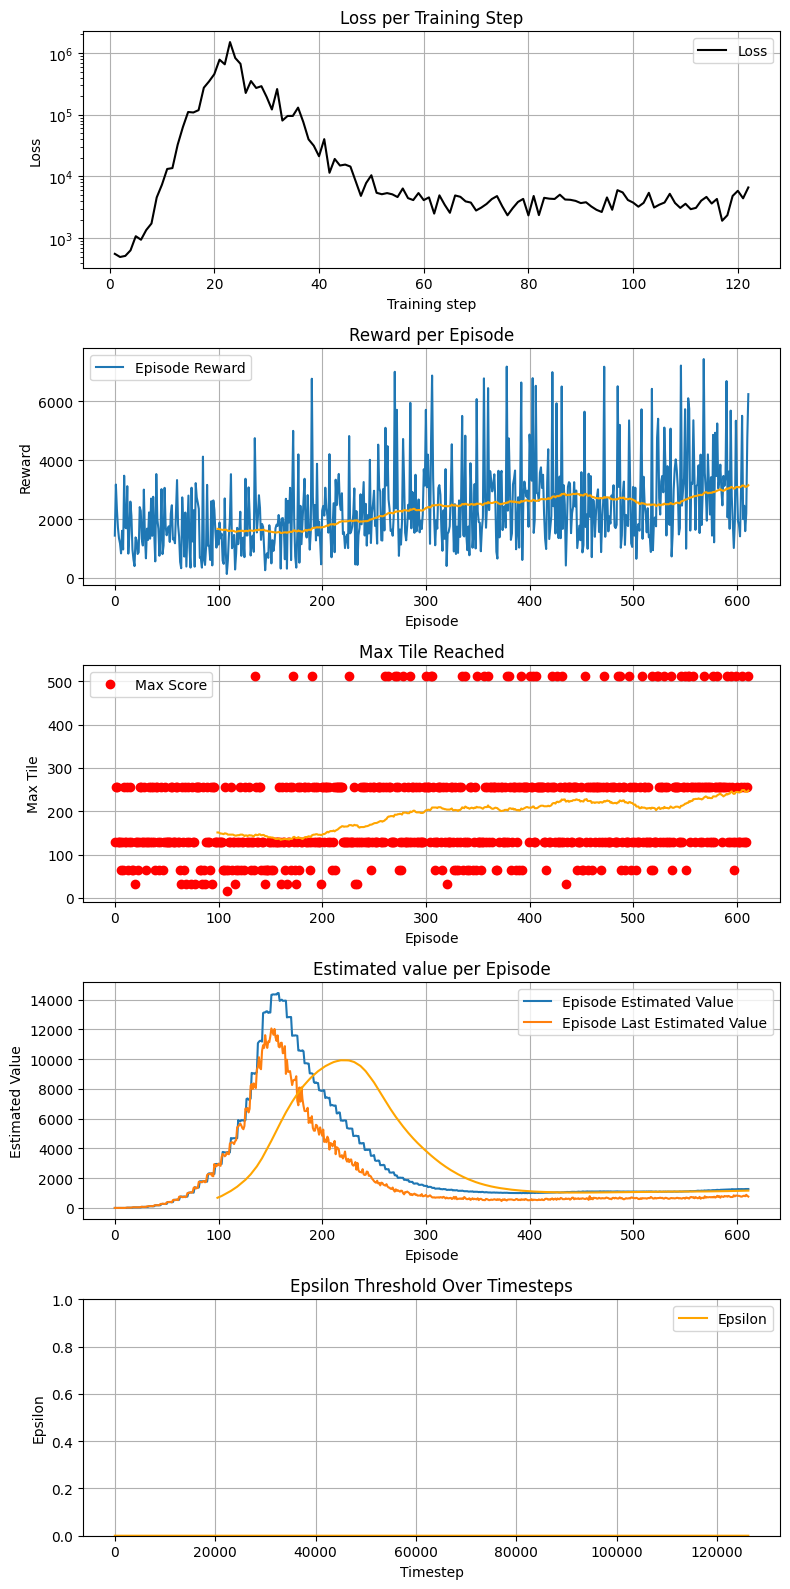

KeyboardInterrupt: 

In [58]:
#profiler = cProfile.Profile()
#profiler.enable()

model.learn(
    1e7, 
    learning_rate=1e-3, 
    gamma=0.99, 
    buffer_size=1024, 
    exploration_initial_eps=0.0, 
    exploration_final_eps=0.0, 
    exploration_fraction=0.1, 
    train_freq=1024, 
    batch_size=1024, 
    target_network_update_freq=-1, # -1 for no target network 
    prioritized_replay=False, 
    prioritized_replay_alpha=0.6, 
    prioritized_replay_beta0=0.4, 
    prioritized_replay_beta_increment=1e-4, 
    prioritized_replay_eps=1e-6,
    prioritized_replay_update_freq=500, 
    checkpoint_path='./exp/TDL_CNN_2024_11_29/', 
    checkpoint_freq=2500, 
    check_gradient_freq=500, 
    restart_jump=False, 
    use_symmetry=True
    )

#profiler.disable()
#stats = pstats.Stats(profiler)

# Training PPO

In [65]:
model = PPO(CNN22_ActorCritic, env, shared_features_extractor=False, device="mps")

model.learn(
    10000, 
    learning_rate=1e-4, 
    gamma=0.99, 
    gae_lambda=0.95,
    vf_coef=0.5,
    checkpoint_path='./exp/PPO_CNN_2024_11_30/', 
    checkpoint_freq=2500
    )

TypeError: only integer scalar arrays can be converted to a scalar index

# Evaluation

In [49]:
profiler = cProfile.Profile()
profiler.enable()

env = gym2048()
model = TDL(CNN22, env)
model.load_network('./exp/TDL_CNN_2024_11_18/rl_model_10000_epsiodes.zip')

model.eval()

model.policy_network.to('cpu')

model.env.playOneGame(policy=model.select_expectimax_action, verbose=True, depth=3, device='cpu')

profiler.disable()
stats = pstats.Stats(profiler)
stats.dump_stats('./profile_results.prof')

Step: 100
[[  2   0   0   2]
 [  4   8   4   0]
 [  4  16  32   4]
 [  4 128   8   4]]
Step: 200
[[  0   0   2   2]
 [  0   8   4 128]
 [  0  16   8   8]
 [  2   4 256   2]]
Step: 300
[[  0   4   2   0]
 [  2   8   2   0]
 [  4  64  16   2]
 [  4 512  32   4]]
Step: 400
[[  2   0   0   2]
 [  4   4   8   2]
 [256   2   4   4]
 [512  64  16   2]]
Step: 500
[[   4    4    8    0]
 [  32    4    2    0]
 [  16 1024    0    0]
 [   2    0    0    0]]
Step: 600
[[   2    2    0    0]
 [ 128    8    0    0]
 [1024  128    0    0]
 [   2    4    2    4]]
Step: 700
[[   4   16  128 1024]
 [   4   64  256    4]
 [   0    4    4    2]
 [   0    8    2    0]]
Step: 800
[[   0    4    0    2]
 [   0    8   16  128]
 [   0    4   32    4]
 [   2  512 1024    2]]
Step: 900
[[   2    0    0    0]
 [   4    0    0    2]
 [  16   32  256   16]
 [  32   64  512 1024]]
Step: 1000
[[   0    0    2    2]
 [   0 2048   32    2]
 [   0    0   16   64]
 [   0    0   16    2]]
Step: 1100
[[   0    0    2    2]

In [8]:
env = gym2048()
model = TDL(CNN22, env)
model.load_network('./exp/TDL_CNN_2024_11_18/rl_model_10000_epsiodes.zip')

model_max_tiles, model_n_steps = env.evaluate(policy=model.select_expectimax_action, n_games=250, depth=2)

data = {
    'max_tiles': model_max_tiles,
    'n_steps': model_n_steps
    }

with open('./exp/TDL_CNN_2024_11_18/stats_10000_episodes_expectimax2.pkl', 'wb') as file:
    pickle.dump(data, file)

100%|██████████| 250/250 [4:58:41<00:00, 71.69s/it]  


# Comparison

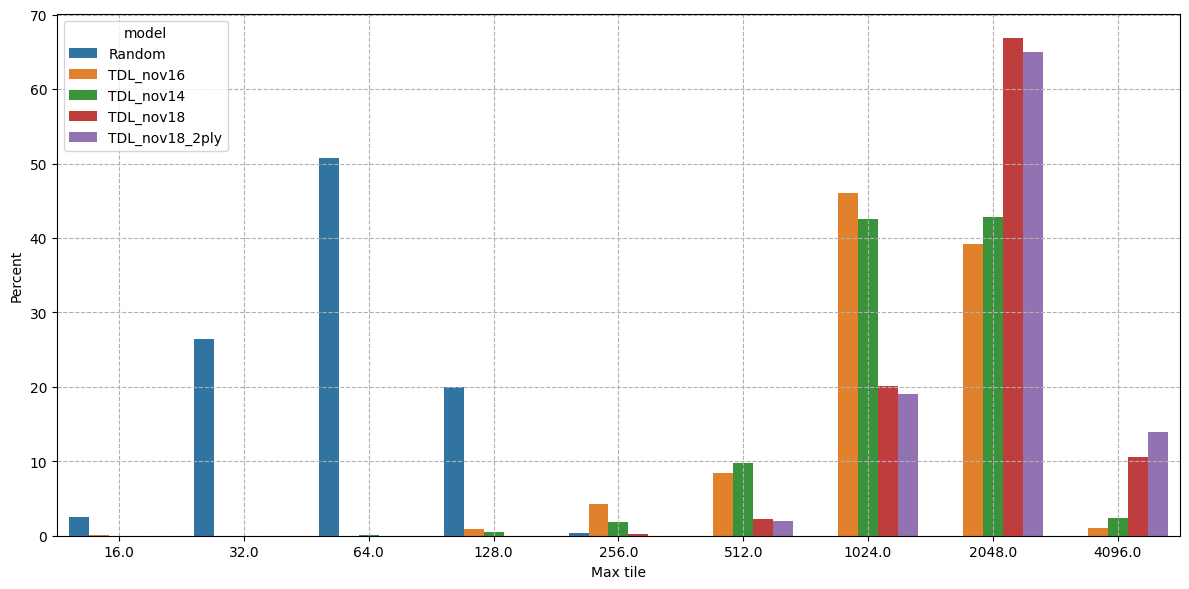

In [ ]:
models = {
    'Random': './exp/2048_random.pkl',
    'TDL_nov14': './exp/TDL_CNN_2024_11_14_1/stats_10000_episodes.pkl',
    'TDL_nov16': './exp/TDL_CNN_2024_11_16/stats_10000_episodes.pkl',
    'TDL_nov18': './exp/TDL_CNN_2024_11_18/stats_10000_episodes.pkl',
    'TDL_nov18_2ply': './exp/TDL_CNN_2024_11_18/stats_10000_episodes_expectimax2.pkl'
}

df = pd.DataFrame()

for id, path in models.items():
    with open(path, 'rb') as file:
        data = pickle.load(file)
    df_loc = pd.DataFrame({'max_tiles':data['max_tiles']})
    df_loc['model'] = id
    df = pd.concat([df, df_loc], ignore_index=True)

df = (df.groupby(['max_tiles', 'model']).size()/10).reset_index(name='counts')

plt.figure(figsize=(12, 6))
sns.barplot(data=df, x='max_tiles', y='counts', hue='model')
plt.xlabel('Max tile')
plt.ylabel('Percent')
plt.tight_layout()
plt.grid(linestyle='--')
plt.show()